## Average Glove Embeddings

**Nov 17, 2019**

---

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import csv
import math
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src import constants
from src.models.avg_embeddings_model import preprocessing
import matplotlib.pyplot as plt
import time

In [2]:
clean_dir = constants.CLEAN_DIR
art_prefix = constants.Text_Prefix
img_prefix = constants.Media_Prefix
tag_types = ['org', 'place', 'subject','person']
article_summary = pd.read_csv(f'{clean_dir}/{art_prefix}summary.csv')
image_summary =  pd.read_csv(f'{clean_dir}/{img_prefix}summary.csv')
preview_dir = f'{constants.DATA_DIR}/preview'

glove_dir = f'{constants.DATA_DIR}/glove'

In [3]:
D = 50
glove_data_file = f'{glove_dir}/glove.6B.{D}d.txt'
words = pd.read_csv(glove_data_file, sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)
words_dict = {word: embed for word, embed in zip(words.index, words.values)}

In [4]:
def vec(w):
    try:
        return words_dict[w]
    except:
        return np.zeros(D)

def average_embedding(sentence):
    total_embeddings = np.zeros(D)
    num_words = len(sentence.split())
    if num_words == 0:
        return total_embeddings
    for word in sentence.split():
        emb = vec(word)
        total_embeddings += vec(word)
    avg_embeddings = total_embeddings/num_words
    return avg_embeddings/np.linalg.norm(avg_embeddings)

In [5]:
# article headline embeddings
article_embeddings = np.zeros(shape=(len(article_summary), D))
start_time = time.time()
for i, text in enumerate(article_summary.headline.values):
    if i % 10000 == 0 and i > 0:
        time_it = time.time() - start_time
        print(f'{i} of {len(article_summary)} articles in {time_it:.2f}s')
    text_prep = preprocessing(text)
    emb = average_embedding(text_prep)
    article_embeddings[i] = average_embedding(text_prep)/np.linalg.norm(emb)
    
print('saving article embeddings\n')
np.save(f'{constants.DATA_DIR}/article_headline_embeddings.npy', article_embeddings)

# image summary embeddings
image_embeddings = np.zeros(shape=(len(image_summary), D))
start_time = time.time()
for i, text in enumerate(image_summary.summary.values):
    if i % 10000 == 0 and i > 0:
        time_it = time.time() - start_time
        print(f'{i} of {len(image_summary)} images in {time_it:.2f}s')
    text_prep = preprocessing(text)
    emb = average_embedding(text_prep)
    image_embeddings[i] = emb
    
print('saving image embeddings')
np.save(f'{constants.DATA_DIR}/image_summary_embeddings.npy', image_embeddings)

10000 of 22602 articles in 0.83s
20000 of 22602 articles in 1.68s
saving article embeddings

10000 of 78521 images in 2.08s
20000 of 78521 images in 4.05s
30000 of 78521 images in 6.02s
40000 of 78521 images in 7.97s
50000 of 78521 images in 9.92s
60000 of 78521 images in 11.87s
70000 of 78521 images in 13.81s
saving image embeddings


In [6]:
image_embeddings_load = np.load(f'{constants.DATA_DIR}/image_summary_embeddings.npy')
article_embeddings_load = np.load(f'{constants.DATA_DIR}/article_headline_embeddings.npy')

Muslim cabbies' ingenuity build airport parking lot mosque

Top 6 matching articles
Jerusalem demolishes Palestinian home built without permit
The Latest: HK police tear gas protesters in shopping area
'Great Move' begins to relocate Istanbul Airport
Waymo bringing self-driving trucks to Phoenix area freeways
Across Baghdad, a moment of respite and guarded hope
Churches arm, train congregants in wake of mass shootings

Top 6 matching images
total prediction time 0.14s


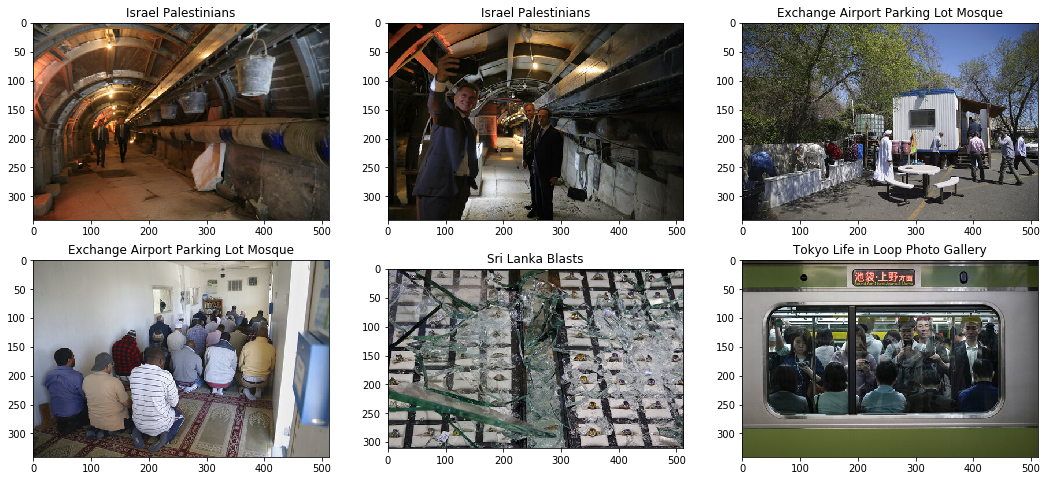

In [7]:
start_time = time.time()
random_ind = np.random.randint(0, len(article_summary))
random_article = article_summary.iloc[random_ind].headline
print(random_article + '\n')
text_prep = preprocessing(random_article)
emb = average_embedding(text_prep)
emb = emb.reshape(-1,1)/np.linalg.norm(emb)

# finding nearest neighbors articles
k = 6
scores_articles = np.dot(article_embeddings_load, emb).flatten()
scores_articles[random_ind] = 0
top_k_articles = np.argsort(-scores_articles)[:k]

print(f'Top {k} matching articles')
for ind in top_k_articles:
    print(article_summary.iloc[ind].headline)

scores_images = np.dot(image_embeddings_load, emb).flatten()
top_k_images = np.argsort(-scores_images)[:k]

print(f'\nTop {k} matching images')

rows = math.ceil(k/3)
cols = 3
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(6*cols,4*rows))
ax = ax.ravel()
for i,ind in enumerate(top_k_images):
    image = image_summary.iloc[ind]
    img_file = plt.imread(f'{preview_dir}/{image.id}.jpg')
    ax[i].imshow(img_file)
    ax[i].set_title(image.title)
print(f'total prediction time {time.time() - start_time:.2f}s')

---